In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv('../.env')

True

In [3]:
# import os
# del os.environ['HF_TOKEN']
# os.environ.get("HF_TOKEN")

In [4]:
from autodm.llm import get_llm, Gemini
from autodm.roll import Dice, DiceType
from autodm.character import Character
from autodm.locaitons import Location, LocationGraph, setup_new_locations
from autodm.adventurelog import AdventureLog
from autodm.storyline import StoryLineWithStoryItems

from typing import List
from rich import print

/Users/michaelfrantz/miniconda3/envs/autodm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/michaelfrantz/miniconda3/envs/autodm/lib/python3.11/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_id" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [6]:
locations = setup_new_locations(storyline="The adventurers enter a sandy desert region")

In [7]:
region = locations[locations.list_locations('region').pop()]
city = locations[locations.list_locations('city').pop()]

In [8]:
building = city.generate_child(type='building', storyline="The adventurers enter the wizard's guild")
room1 = building.generate_child(storyline="The adventurers find and enter the wizard's library.")
room2 = building.generate_child(storyline="The adventurers find and enter thewizard's alchemy lab")
room3 = building.generate_child(storyline="The adventurers find and enter thewizard's training range")
locations.add_location(building)
locations.add_location(room1)
locations.add_location(room2)
locations.add_location(room3)
locations.set_current_location(room1.name)

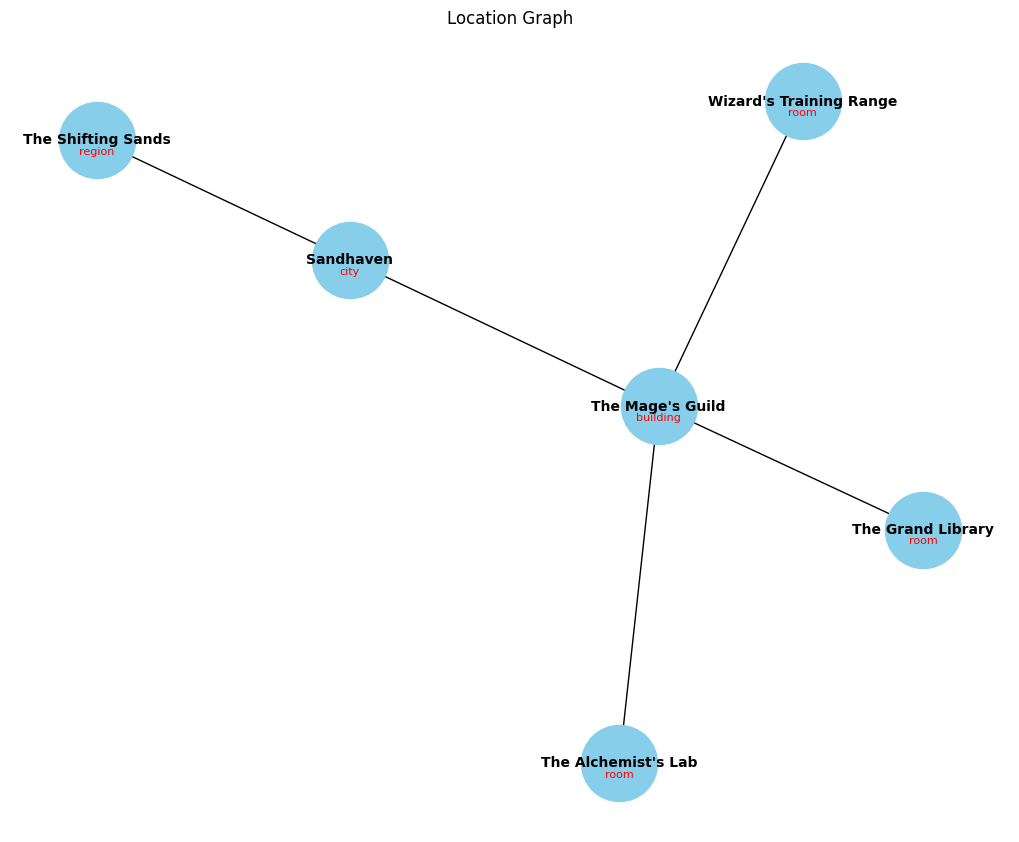

In [9]:
locations.visualize()

In [10]:
character = Character.generate(level=0)
print(character)

Character(
    chr_class='fighter',
    chr_race='dwarf',
    name='Grung',
    attributes=Attributes(strength=16, dexterity=4, constitution=19, intelligence=12, wisdom=8, charisma=2),
    level=0,
    max_hp=29,
    hp=29,
    spells=[],
    equipment=[]
)

In [11]:
story = StoryLineWithStoryItems.generate(character, city, region, locations)

In [12]:
print(story)

StoryLineWithStoryItems(
    name='The Sandhaven Mystery',
    details="The party arrives in Sandhaven, a bustling city nestled within the vast Shifting Sands. Rumors swirl 
of a strange and unsettling phenomenon: the Grand Library, usually overflowing with knowledge, has fallen eerily 
silent. No one can enter or leave, and a thick, unnatural fog hangs around the building. The Mage's Guild, 
concerned about the potential threat, has issued a plea for adventurers to investigate the situation. The party 
must navigate the treacherous Shifting Sands, explore the library's secrets, and uncover the truth behind the 
haunting fog.",
    completed=False,
    items=StoryItems(
        items=[
            StoryItem(
                name='Navigating the Shifting Sands',
                details='The party must traverse the treacherous Shifting Sands to reach the Grand Library. This 
journey is fraught with danger, as the sands constantly shift, creating treacherous sandstorms and shifting dunes. 
They might encounter lost travelers, monstrous creatures adapted to the harsh environment, or even ancient ruins 
buried beneath the sand.',
                completed=False
            ),
            StoryItem(
                name='The Silent Library',
                details='Upon reaching the Grand Library, the party discovers a thick, unnatural fog engulfing the 
building. They must find a way to penetrate the fog, possibly by using magic or finding a hidden entrance. Inside, 
the library is eerily silent, with no sign of life. Books lie scattered and dusty, as if abandoned in haste.',
                completed=False
            ),
            StoryItem(
                name='Unveiling the Secrets',
                details="Exploring the library, the party discovers clues about the cause of the fog and the 
disappearance of its inhabitants. They might find ancient texts hinting at a powerful magical artifact, a hidden 
journal detailing the library's caretaker's desperate attempts to stop something, or perhaps a ghostly apparition 
revealing the truth.",
                completed=False
            ),
            StoryItem(
                name='Confronting the Source',
                details='Following the clues, the party discovers the source of the fog - a powerful magical entity
trapped within the library, attempting to escape. The entity might be a corrupted spirit, a malevolent force, or 
even a forgotten god seeking to reclaim its power. The party must confront this entity in a climactic battle, using
their skills and knowledge to defeat it.',
                completed=False
            ),
            StoryItem(
                name='The Fog Lifts',
                details="After defeating the entity, the unnatural fog dissipates, revealing the Grand Library in 
its former glory. The party is hailed as heroes by the grateful citizens of Sandhaven, who celebrate their victory 
and the return of their beloved library. The Mage's Guild may offer rewards, and the party may even be granted 
access to the library's vast knowledge as a sign of gratitude.",
                completed=False
            )
        ]
    )
)

In [13]:
from llama_index.core.tools import FunctionTool
from llama_index.core.agent import ReActAgent
from llama_index.core.program import LLMTextCompletionProgram
from llama_index.core import PromptTemplate
from pydantic import BaseModel, Field
import typing as T

In [14]:
def get_current_location(*args, **kwargs) -> str:
    """
    Returns the name of the current location.
    
    Returns:
        str: The name of the current location.
    """
    return locations.current_location.name

def locaiton_info(location_name, *args, **kwargs) -> str:
    """
    Returns the information about a location.
    
    Args:
        location_name (str): The name of the location.
        
    Returns:
        str: The information about the location.
    """
    if location_name not in locations.list_locations():
        return f"Location {location_name} not found. Use list_locations or get_current_neighbors to see available locations, or create a new location."
    loc = locations[location_name].model_dump()
    s = "\n".join([f"{k}: {v}" for k, v in loc.items()])
    return s

def get_current_neighbors(num_skips:int=1, *args, **kwargs) -> List[str]:
    """
    Returns the names of the neighbors of the current location.
    
    Args:
        num_skips (int): The number of steps to skip in the graph traversal.
        
    Returns:
        List[str]: The names of the neighbors of the current location.
    """
    return locations.current_neighbors(num_skips)

def add_new_location(storyline:str, parent_name:str=None, location_name:str=None, *args, **kwargs) -> str:
    """
    Adds a new location to the location graph.
    
    Args:
        storyline (str): The storyline related to the creation of the new location. 
        parent_name (str): The name of the parent location. If none is given, the current location is used.
        location_name (str): The name of the location. If none is given, one will be made up.
        
    Returns:
        str: The name of the new location.
    """
    if not parent_name:
        parent = locations.current_location
    else:
        parent = locations[parent_name]
    kwargs = {}
    if location_name is not None:
        kwargs["name"] = location_name
    location = parent.generate_child(storyline=storyline, **kwargs)
    locations.add_location(location)
    return location.name

def travel_plan(destionation_name:str, *args, **kwargs) -> List[str]:
    """
    Returns a list of location names that the character will travel through to reach the destination.

    Args:
        destionation_name (str): The name of the destination location.

    Returns:
        str: The name of the destination location.

    Example:
    travel_plan(destination_name="Doom's chasm")
    """
    return locations.travel_plan(destionation_name)

def travel_to(destination_name:str, *args, **kwargs) -> str:
    """
    Travels to a location.
    
    Args:
        destination_name (str): The name of the destination location.
        
    Returns:
        str: The name of the destination location.
    """
    locations.set_current_location(destination_name)
    return locations.current_location.name

In [15]:
location_tools = [
    FunctionTool.from_defaults(get_current_location),
    FunctionTool.from_defaults(locaiton_info),
    FunctionTool.from_defaults(add_new_location),
    FunctionTool.from_defaults(travel_plan),
    FunctionTool.from_defaults(travel_to),
    FunctionTool.from_defaults(get_current_neighbors)
]

In [16]:
location_agent = ReActAgent.from_tools(location_tools, llm=get_llm(), verbose=2)
# location_agent = StructuredPlannerAgent.from_tools(location_tools, llm=get_llm(), verbose=2)

In [17]:
step_splitting_instructions = """\
You will get a piece of a story from a dungeons and dragons campaign. \
The task is to break the story into steps that relate to location. \
If no steps are required (for example, the storyline is a conversation), return an empty list. \
Please follow the requested JSON schema. \

Examples:
------
Input: "The adventurers enter the wizard's guild."
Answer: {"steps": ["What is the current location?", \
"What are the available locations?", \
'Does the wizard's guild exist?', \
"Create the wizard's guild if it doesn't exist.", \
"Create a travel plan to the wizard's guild.", \
"Travel to the Mirendale wizard's guild."]}
------
Input: "The adventurers set out on a journey to the city of Mirendale."
Answer: {"steps": ["What is the current location?", \
"Create the city of Mirendale if it doesn't exist", \
"Create a travel plan to the city of Mirendale.", \
"Take the first step in traveling to Mirendale."]}
------

Now perform the demonstrated task on the folloing input:
"""

step_splitting_template = PromptTemplate("""\
{step_splitting_instructions}
{storyline}
Answer: \
""").partial_format(step_splitting_instructions=step_splitting_instructions)

class Steps(BaseModel):
    steps: List[str] = Field([], description="The steps to take to complete the storyline.")

split_prompts_program = LLMTextCompletionProgram.from_defaults(output_cls=Steps, llm=get_llm(output_cls=Steps), prompt=step_splitting_template)

In [18]:
# steps = split_prompts_program(storyline="Let's go to the alchemy lab.").steps

In [19]:
inst = f"""\
Here is the current location: {locations.current_location.name}
Here are the nearest locations: {locations.current_neighbors()}
Let's travel to the alchemist's lab.
"""

In [20]:
output = location_agent.chat(inst)

Thought: I understand the user wants to travel to "The Alchemist's Lab". I will use the `travel_to` tool.
Action: travel_to
Action Input: {'destination_name': "The Alchemist's Lab"}
Observation: The Alchemist's Lab
Thought: I can answer without using any more tools. I'll use the user's language to answer
Answer: You are now at The Alchemist's Lab.


In [21]:
print(output)

AgentChatResponse(
    response="You are now at The Alchemist's Lab.",
    sources=[
        ToolOutput(
            content="The Alchemist's Lab",
            tool_name='travel_to',
            raw_input={'args': (), 'kwargs': {'destination_name': "The Alchemist's Lab"}},
            raw_output="The Alchemist's Lab",
            is_error=False
        )
    ],
    source_nodes=[],
    is_dummy_stream=False
)

In [22]:
print(output.response)

You are now at The Alchemist's Lab.

In [23]:
locations.current_location

Location(name=The Alchemist's Lab, type=room, description=The Alchemist's Lab is a cluttered room, filled with bubbling flasks, strange herbs, and arcane paraphernalia. The air is thick with the scent of exotic spices and burning incense. The walls are lined with shelves overflowing with books, scrolls, and vials of colorful liquids. A large, ornate table in the center of the room is covered with tools and materials for alchemy, including a mortar and pestle, a crucible, and a set of delicate scales. A lone, flickering candle illuminates the room, casting long, dancing shadows across the walls. A small, dusty window in the corner of the room provides a glimpse of the bustling city streets below., parent_name=The Mage's Guild

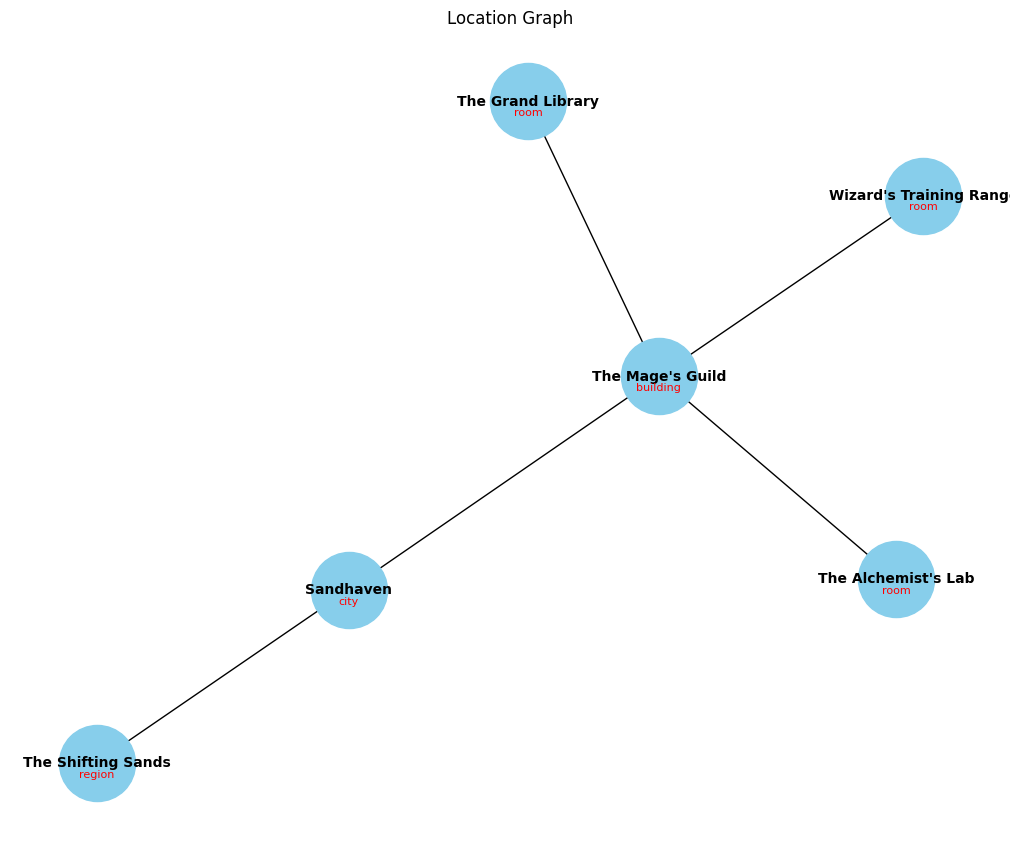

In [24]:
locations.visualize()